In [ ]:
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 15.9 MB/s 
     |████████████████████████████████| 13.6 MB 66.5 MB/s 
     |████████████████████████████████| 1.6 MB 73.2 MB/s 
     |████████████████████████████████| 108 kB 77.8 MB/s 


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import autograd.numpy as anp
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

import time
import datetime

import json

SEED = 42
def seed_everything(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)  # type: ignore
  torch.backends.cudnn.deterministic = True  # type: ignore
  torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(seed = SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(f"Device: {device}")

Mounted at /content/drive
Device: cuda


In [ ]:
class MakingDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    image = self.X[index]
    label = self.y[index]
    return image, label

  def __len__(self):
      return len(self.y)


class TrainTestLoader(object):
  def __init__(self, dataset="CIFAR10", feature_reduction='pca', size=16):
    self.dataset = dataset

    self.training_data=None
    self.test_data=None

    self.train_X = None
    self.train_y = None
    self.test_X = None
    self.test_y = None

    if self.dataset == "CIFAR10":
      download_root = "./CIFAR10_DATASET"
      CIFAR10_transform = transforms.Compose([
                    transforms.ToTensor()
                  ])
      self.training_data = CIFAR10(download_root,
                        train=True,
                        download=True,
                        transform=CIFAR10_transform)

      self.test_data = CIFAR10(download_root,
                        train=False,
                        download=True,
                        transform=CIFAR10_transform)

      train_X = torch.Tensor(self.training_data.data) / 255.0
      train_y = torch.Tensor(self.training_data.targets)

      test_X = torch.Tensor(self.test_data.data) / 255.0
      test_y = torch.Tensor(self.test_data.targets)

      # airplane(index=0), dog(index=5)에 해당하는 데이터만 추출
      self.train_X = train_X[(train_y==0) | (train_y==5)]
      self.train_y = train_y[(train_y==0) | (train_y==5)]
      self.test_X = test_X[(test_y==0) | (test_y==5)][:1000]
      self.test_y = test_y[(test_y==0) | (test_y==5)][:1000]

      # airplane은 0으로 dog는 1로 index변환
      self.train_y = torch.where(self.train_y==0, 0, 1)
      self.test_y = torch.where(self.test_y==0, 0, 1)
    

    if self.dataset == "CIFAR10" and feature_reduction=='resize':
      size = int(np.sqrt(size))
      t = transforms.Resize(size=(size, size))
      train_X_p = self.train_X.permute(0,3,1,2)
      test_X_p = self.test_X.permute(0,3,1,2)
      train_X = t(train_X_p).permute(0,2,3,1)
      test_X = t(test_X_p).permute(0,2,3,1)

      self.train_X = train_X.reshape((train_X.shape[0],
                                    train_X.shape[1]*train_X.shape[2],
                                      train_X.shape[3]))
      self.test_X = test_X.reshape((test_X.shape[0],
                                    test_X.shape[1]*test_X.shape[2],
                                      test_X.shape[3]))
    
    elif self.dataset == "CIFAR10" and feature_reduction=='pca':
      train_shape = self.train_X.shape
      test_shape = self.test_X.shape
      train_X = self.train_X.reshape((train_shape[0],
                                      train_shape[1]*train_shape[2],
                                      train_shape[3]))
      test_X = self.test_X.reshape((test_shape[0],
                                      test_shape[1]*test_shape[2],
                                      test_shape[3]))
      train_X_pca =\
                np.zeros((train_shape[0], size, train_shape[3]))
      test_X_pca =\
                np.zeros((test_shape[0], size, test_shape[3]))
      #channel별로 pca적용
      for channel in range(train_shape[-1]):
        pca = PCA(n_components = size)
        train_X_pca[:,:,channel] = pca.fit_transform(train_X[:,:,channel])
        test_X_pca[:,:,channel] = pca.transform(test_X[:,:,channel])
        if size <= 30:
          ### Rescale for angle embedding
          train_X_scale = train_X_pca[:,:,channel]
          test_X_scale = test_X_pca[:,:,channel]
          train_X_pca[:,:,channel] = (train_X_scale - train_X_scale.min())\
                         * (np.pi / (train_X_scale.max() - train_X_scale.min()))
          test_X_pca[:,:,channel] = (test_X_scale - test_X_scale.min())\
                         * (np.pi / (test_X_scale.max() - test_X_scale.min()))

      self.train_X = torch.Tensor(train_X_pca)
      self.test_X = torch.Tensor(train_X_pca)


  def return_dataset(self):
      return MakingDataset(self.train_X, self.train_y), MakingDataset(self.test_X, self.test_y)



In [ ]:
class EmbeddingMethod():
  def __init__(self, n_qubits = 24, embedding_type = "Angle-compact"):
    self.n_qubits = n_qubits
    self.embedding_type = embedding_type
  
  def embed_data (self, inputs):
    if self.embedding_type == "Amplitude": # need (2^n_qubits) features
      qml.AmplitudeEmbedding(inputs, wires=range(self.n_qubits//3),
                           pad_with=0, normalize=True)

    elif self.embedding_type == 'Angle-compact': # 16 classical bits in 8 qubits
      qml.AngleEmbedding(inputs[0:8],
                          wires=range(8), rotation='X')
      qml.AngleEmbedding(inputs[8:16],
                          wires=range(8), rotation='Y')

    elif self.embedding_type == "HybridAngle_2":
      N = 3  # 3 classical bits in 2 qubits
      X1 = inputs[:N]
      X2 = inputs[N:2*N]
      X3 = inputs[2*N:3*N]
      X4 = inputs[3*N:4*N]
      self.Angular_Hybrid_2(X1, wires=[0,1])
      self.Angular_Hybrid_2(X2, wires=[2,3])
      self.Angular_Hybrid_2(X3, wires=[4,5])
      self.Angular_Hybrid_2(X4, wires=[6,7])

    elif self.embedding_type == "HybridAngle_4":
      N = 15 # 15 classical data in 4 qubits
      X1 = inputs[:N]
      X2 = inputs[N:2*N]
      self.Angular_Hybrid_4(X1, wires=[0, 1, 2, 3])
      self.Angular_Hybrid_4(X2, wires=[4, 5, 6, 7])


  # Hybrid Angle Embedding
  
  def Angular_Hybrid_2(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])
  
  def Angular_Hybrid_4(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])

    qml.RY(X[3], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[4], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.RY(X[5], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[6], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])

    qml.RY(X[7], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[8], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[9], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[10], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.RY(X[11], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[12], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[13], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[14], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])



In [ ]:
# Unitary Ansatze for Convolutional Layer

class U_TTN():  # Convolutional circuit 1 - 2 params
  def __init__(self) -> None:
    self.num_params = 2
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    
class U_5(): # 10 params
  def __init__(self) -> None:
    self.num_params = 10
  
  def apply(self, params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

class U_6():  # 10 params
  def __init__(self) -> None:
    self.num_params = 10
  
  def apply(self, params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

class U_9():  # 2 params
  def __init__(self) -> None:
    self.num_params = 2
  
  def apply(self, params, wires):
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])

class U_13():  # 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])

class U_14():  # 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])

class U_15():  # 4 params
  def __init__(self) -> None:
    self.num_params = 4
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

class U_SO4():  # Convolutional circuit 6 - 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])

class U_SU4(): # Convolutional circuit 9 - 15 params
  def __init__(self) -> None:
    self.num_params = 15
  
  def apply(self, params, wires):
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])


  # Pooling Layer
class Pooling_ansatz1(): #2 params
  def __init__(self) -> None:
      self.num_params = 2
  def apply(self, params, wires):
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

class Pooling_ansatz2(): #0 params
  def __init__(self) -> None:
    self.num_params = 0
  def apply(self, params, wires):
    qml.CRZ(wires=[wires[0], wires[1]])

class Pooling_ansatz3(): #3 params
  def __init__(self) -> None:
    self.num_params = 3
  def apply(self, *params, wires):
    qml.CRot(*params, wires=[wires[0], wires[1]])

# final layer ansatz
class Final_ansatz1():  #ConvCircSU4변형
  def __init__(self)->None:
    self.num_params = 18
  def apply(self, weights, wires):
    qml.U3(weights[0], weights[1], weights[2], wires = wires[0])
    qml.U3(weights[3], weights[4], weights[5], wires = wires[1])
    qml.CNOT(wires = [wires[0], wires[1]])
    qml.RY(weights[6], wires = wires[0])
    qml.RZ(weights[7], wires = wires[1])
    qml.CNOT(wires = [wires[1], wires[0]])
    qml.RY(weights[8], wires=wires[0])
    qml.CNOT(wires = [wires[0], wires[1]])

    qml.U3(weights[9], weights[10], weights[11], wires = wires[1])
    qml.U3(weights[12], weights[13], weights[14], wires = wires[2])
    qml.CNOT(wires = [wires[1], wires[2]])
    qml.RY(weights[15], wires = wires[1])
    qml.RZ(weights[16], wires = wires[2])
    qml.CNOT(wires = [wires[2], wires[1]])
    qml.RY(weights[17], wires=wires[1])
    qml.CNOT(wires = [wires[2], wires[1]])



In [ ]:
class QCNN(nn.Module):
  def __init__(self, n_qubits, embedding_type, conv_ansatz, pooling_ansatz,
               cost_fn):
    super(QCNN, self).__init__()
    self.n_qubits = n_qubits
    self.cost_fn = cost_fn
    self.embedding_method = EmbeddingMethod(n_qubits = n_qubits,
                                            embedding_type = embedding_type)
    if conv_ansatz == "U_TTN":
      self.conv_ansatz = U_TTN()
    elif conv_ansatz == "U_SU4":
      self.conv_ansatz = U_SU4()

    if pooling_ansatz == "Pooling_ansatz1":
      self.pooling_ansatz = Pooling_ansatz1()
    elif pooling_ansatz == "Pooling_ansatz2":
      self.pooling_ansatz = Pooling_ansatz2()
    elif pooling_ansatz == "Pooling_ansatz3":
      self.pooling_ansatz = Pooling_ansatz3()

    weight_shapes = { "weights1": (self.conv_ansatz.num_params,),
                      "weights2": (self.pooling_ansatz.num_params,),
                      "weights3": (self.conv_ansatz.num_params,),
                      "weights4": (self.pooling_ansatz.num_params,),
                      "weights5": (self.conv_ansatz.num_params,),
                      "weights6": (self.pooling_ansatz.num_params,)}

    dev = qml.device("default.qubit", wires=self.n_qubits//3)
    @qml.qnode(dev, interface="torch")
    def qnode(inputs, weights1, weights2, weights3,
                    weights4, weights5, weights6):
      self.embedding_method.embed_data(inputs)

      self.conv_layer1(weights1)
      self.pooling_layer1(weights2)
      self.conv_layer2(weights3)
      self.pooling_layer2(weights4)
      self.conv_layer3(weights5)
      self.pooling_layer3(weights6)

      return [qml.expval(qml.PauliX(4)), qml.expval(qml.PauliY(4)), qml.expval(qml.PauliZ(4))]

    init_method = torch.nn.init.normal_
    self.qlayer0 = qml.qnn.TorchLayer(qnode, weight_shapes,
                                          init_method=init_method)
    self.qlayer1 = qml.qnn.TorchLayer(qnode, weight_shapes,
                                          init_method=init_method)
    self.qlayer2 = qml.qnn.TorchLayer(qnode, weight_shapes,
                                          init_method=init_method)
    if self.cost_fn == "mse":
      self.final_layer = nn.Linear(9,1, bias = True)
      
    elif self.cost_fn == "cross_entropy":
      self.final_layer = nn.Linear(9,2, bias = True)
      self.softmax = nn.Softmax(dim=1)
    nn.init.normal_(self.final_layer.weight)

  def forward(self, data):
    x0 = self.qlayer0(data[:,:,0])
    x1 = self.qlayer1(data[:,:,1])
    x2 = self.qlayer2(data[:,:,2])
    x = torch.hstack([x0,x1,x2]).float()
    out = self.final_layer(x)

    if self.cost_fn == "mse":
      pass
    elif self.cost_fn == "cross_entropy":
      out = self.softmax(out)

    return out


  # Convolutional layers
  def conv_layer1(self, params):
    self.conv_ansatz.apply(params, wires=[0, 7])
    for i in range(0, 8, 2):
      self.conv_ansatz.apply(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
      self.conv_ansatz.apply(params, wires=[i, i + 1])
  
  def conv_layer2(self, params):
    self.conv_ansatz.apply(params, wires=[0, 6])
    self.conv_ansatz.apply(params, wires=[0, 2])
    self.conv_ansatz.apply(params, wires=[4, 6])
    self.conv_ansatz.apply(params, wires=[2, 4])
  
  def conv_layer3(self, params):
    self.conv_ansatz.apply(params, wires=[0,4])

  # Pooling layers
  def pooling_layer1(self, params):
      for i in range(0, 8, 2):
        self.pooling_ansatz.apply(params, wires=[i + 1, i])

  def pooling_layer2(self, params):
    self.pooling_ansatz.apply(params, wires=[2,0])
    self.pooling_ansatz.apply(params, wires=[6,4])

  def pooling_layer3(self, params):
    self.pooling_ansatz.apply(params, wires=[0,4])



In [ ]:
class Trainer():
  def __init__(self, setting):
    self.setting = setting
    self.loss_list = []
    self.history_of_parameters = []
    self.total_time = None

  # iter mode
  def training_model(self, model, train_loader)->None:
    optimizer = self.setting.make_optimizer(model.parameters())
    start_t = time.time()
    iter = 0
    for epoch in range(self.setting.EPOCHS):
      for inputs, labels in train_loader:
        if iter == self.setting.train_iter:
          break

        inputs = inputs.to(torch.float32).to(device)
        if self.setting.cost_fn == "mse":
          labels = labels.reshape(-1,1)
          labels = 2*labels.to(torch.float32).to(device) - 1  # label을 1과 -1로 변환
        elif self.setting.cost_fn == "cross_entropy":
          # 0은 [1,0]으로 1은 [0,1]로 변환
          labels = nn.functional.one_hot(labels).to(torch.float32).to(device)

        optimizer.zero_grad()
        pred = model(inputs)

        loss = self.setting.criterion(pred, labels)
        loss.backward()
        optimizer.step()

        current_param_list = []
        for current_param in model.parameters():
          for current_param_element in current_param.detach().cpu().reshape(-1,1):
            current_param_list.append(current_param_element.item())

        self.history_of_parameters.append(current_param_list)
        np.save(self.setting.filepath+'/'+f'param_of_iter{iter}', current_param_list)

        self.loss_list.append(loss.item())
        # self.setting.writer.add_scalar('training loss', loss.item(), iter)
        
        if (iter+1)%10 == 0:
          print(f"Iteration {iter+1:>3} loss: {loss.item()}")
        iter += 1
    ### train ends
    self.setting.writer.close()
    end_t = time.time()
    sec = end_t - start_t
    self.total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
    print(f"Training during {self.setting.train_iter} iterations finishes (taken time: {self.total_time}) ")




In [ ]:
class Tester():
  def __init__(self, setting):
    self.setting = setting
    self.accuracy = 0
  
  def testing_model(self, model, test_loader)->None:
    with torch.no_grad():
      if self.setting.cost_fn == "mse":
        for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.reshape(-1,1).to(device)
          labels = 2*labels - 1
          pred = model(inputs.to(torch.float32))
          correct = pred*labels > 0 #곱했을 때 부호가 같으면 정답
          self.accuracy = (sum(correct) / len(correct)).item()
          print(f"Test socre: {self.accuracy}")
      elif self.setting.cost_fn == "cross_entropy":
        for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          pred = model(inputs.to(torch.float32))
          pred = pred[:,0] < pred[:,1]
          # 0은 False, 1은 True
          correct = pred == labels
          self.accuracy = (sum(correct) / len(correct)).item()
          print(f"Test socre: {self.accuracy}")



In [ ]:
def saving_summary(setting, trainer, tester):
  with open(setting.filepath+"/"+"summary.json","w") as fp:
    json.dump(dict(
        loss = trainer.loss_list,
        total_time = trainer.total_time,
        accuracy = tester.accuracy
    ), fp = fp)

    

In [ ]:
class Setting():

  def __init__(self, dataset="CIFAR10", n_qubits=24, embedding_type='Angle-compact',
               feature_reduction = "pca", size = 16, EPOCHS = 3,
               train_iter = 200, BATCH_SIZE = 25, LEARNING_RATE = 0.01,
               conv_ansatz="U_TTN", pooling_ansatz="Pooling_ansatz1", cost_fn="cross_entropy",
               filepath="/content/drive/MyDrive/박경덕교수님연구실/QCNN_gpu_NN_3channel"):
    self.dataset=dataset
    self.n_qubits=n_qubits
    self.embedding_type=embedding_type
    self.feature_reduction=feature_reduction
    self.size=size
    self.EPOCHS = EPOCHS
    self.train_iter = train_iter
    self.BATCH_SIZE = BATCH_SIZE
    self.LEARNING_RATE = LEARNING_RATE
    self.conv_ansatz=conv_ansatz
    self.pooling_ansatz=pooling_ansatz
    self.cost_fn=cost_fn
    if cost_fn == "mse":
      self.criterion = nn.MSELoss()
    elif cost_fn == "cross_entropy":
      self.criterion = nn.CrossEntropyLoss()

    loader = TrainTestLoader(dataset = self.dataset,
                             feature_reduction = self.feature_reduction,
                             size = self.size)
    self.train_data, self.test_data = loader.return_dataset()
    # print data sizes
    print(f"Train set #: {len(self.train_data)}")
    # print(f"Validation set #: {len(validation_set)}")
    print(f"Test set #:  {len(self.test_data)}")

    self.filepath = filepath +\
            f"/{feature_reduction}_{embedding_type}_{conv_ansatz}_{cost_fn}_result"
    
    if os.path.exists(self.filepath) == False:
        os.makedirs(self.filepath)
    self.writer = SummaryWriter(log_dir=self.filepath)
  
  def make_model(self):
    return QCNN(n_qubits = self.n_qubits,
                embedding_type = self.embedding_type,
                conv_ansatz = self.conv_ansatz,
                pooling_ansatz = self.pooling_ansatz,
                cost_fn = self.cost_fn)

  def make_optimizer(self, param):
    return optim.Adam(param, lr = self.LEARNING_RATE)

  def make_train_loader(self):
    return DataLoader(self.train_data, batch_size = self.BATCH_SIZE, shuffle=True)

  def make_test_loader(self):
    return DataLoader(self.test_data, batch_size = len(self.test_data), shuffle=False)



In [ ]:
########################## hyper param ##############################
dataset = "CIFAR10"
n_qubits = 24  ## 각 device별로 n_qubits//3 개씩의 qutit을 사용
#### "Amplitude" - 256, "Angle-compact"-16, "HybridAngle_2"-12, "HybridAngle_4"-30
embedding_type="Angle-compact"
feature_reduction='pca' #### "pca" or "resize" ####
size=16
EPOCHS = 5
train_iter = 1000
BATCH_SIZE = 25
LEARNING_RATE = 0.01

conv_ansatz="U_SU4" #### "U_TTN", "U_SU4"
pooling_ansatz="Pooling_ansatz1" #### "Pooling_ansatz1","Pooling_ansatz2", "Pooling_ansatz3"
cost_fn="mse" #### "mse", "cross_entropy"

############file path 필요하면 수정###############
filepath="/content/drive/MyDrive/박경덕교수님연구실/QCNN_gpu_NN_3channel"
########################## hyper param ##############################


setting = Setting(dataset = dataset,
                  n_qubits=n_qubits,
                  embedding_type=embedding_type,
                  feature_reduction = feature_reduction,
                  size = size,
                  EPOCHS = EPOCHS,
                  train_iter = train_iter,
                  BATCH_SIZE = BATCH_SIZE,
                  LEARNING_RATE = LEARNING_RATE,
                  conv_ansatz=conv_ansatz,
                  pooling_ansatz=pooling_ansatz,
                  cost_fn=cost_fn,
                  filepath=filepath)

train_loader = setting.make_train_loader()
test_loader = setting.make_test_loader()

model = setting.make_model().to(device)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10_DATASET/cifar-10-python.tar.gz to ./CIFAR10_DATASET
Files already downloaded and verified
Train set #: 10000
Test set #:  1000


In [ ]:
### params before training
init_param = model.parameters()
for i in init_param:
  print(np.array(i.detach().cpu()))

[ 0.33669037  0.12880941  0.23446237  0.23033303 -1.12285638 -0.18632829
  2.20820141 -0.63799703  0.46165723  0.26735088  0.53490466  0.80935723
  1.11029029 -1.68979895 -0.98895991]
[0.95797181 1.32213509]
[ 0.81718975 -0.76583862 -0.75062233  1.35254776  0.68632191 -0.32775864
  0.79496872  0.28151956  0.05616354  0.52271605 -0.23835687 -0.04990335
  0.52633697 -0.00849882  0.72906059]
[0.13314196 0.86397767]
[-1.01567471 -0.88874853  0.14977971 -0.20889392 -0.38702095  0.99123776
  0.46790305 -0.20493191 -0.74090713  0.36183965  1.91989923 -0.22538756
 -0.34169748  0.30401275 -0.6890136 ]
[-1.1267184  -0.28575504]
[-1.09351099  1.13510227  0.75924522 -3.59446883  0.01915081  0.10517301
  0.96034014 -0.56718057 -0.57064742  1.59803843  0.11148621 -0.0391967
  1.41115391 -0.65561098  0.8576057 ]
[-1.62702429 -1.39513874]
[-0.23872417 -0.5049904  -2.47516322 -0.93160295 -0.13348687  0.34148848
 -0.07157138 -0.09089038 -1.32969224 -0.54258263  0.54709846  0.64306372
 -0.79048109 -0.905

# train model







In [ ]:
############ train model ###########
trainer = Trainer(setting = setting)
trainer.training_model(model=model, train_loader=train_loader)


Iteration  10 loss: 0.741932213306427
Iteration  20 loss: 0.8446778655052185
Iteration  30 loss: 0.6885363459587097
Iteration  40 loss: 0.7981842160224915
Iteration  50 loss: 0.5557280778884888
Iteration  60 loss: 0.5749372839927673
Iteration  70 loss: 0.6759377717971802
Iteration  80 loss: 0.9607812166213989
Iteration  90 loss: 0.6429736018180847
Iteration 100 loss: 0.46615704894065857
Iteration 110 loss: 0.5585662126541138
Iteration 120 loss: 0.39951398968696594
Iteration 130 loss: 0.38864561915397644
Iteration 140 loss: 0.7168676853179932
Iteration 150 loss: 0.552762508392334
Iteration 160 loss: 0.8829144835472107
Iteration 170 loss: 0.8805013298988342
Iteration 180 loss: 0.8609037399291992
Iteration 190 loss: 0.6154350638389587
Iteration 200 loss: 0.553568959236145
Iteration 210 loss: 0.5038852095603943
Iteration 220 loss: 0.529190719127655
Iteration 230 loss: 0.5369115471839905
Iteration 240 loss: 0.5311799645423889
Iteration 250 loss: 0.6246525645256042
Iteration 260 loss: 0.6426

FailedPreconditionError: ignored

In [ ]:
### params after training
for i in model.parameters():
  print(np.array(i.detach().cpu()))


In [ ]:
############ test model ###########
tester = Tester(setting = setting)
tester.testing_model(model, test_loader)


Test socre: 0.5049999952316284


In [ ]:
saving_summary(setting, trainer, tester)

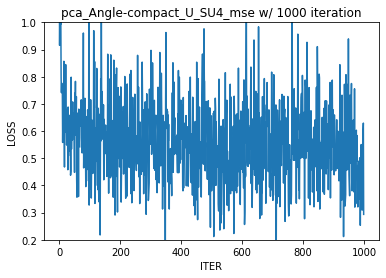

In [ ]:
############### loss plot ################

# loss_list
plt.plot(trainer.loss_list)
plot_title = "_".join(setting.filepath.split("/")[-1].split("_")[:-1])
plt.title(f"{plot_title} w/ {str(setting.train_iter)} iteration")
plt.xlabel("ITER")
plt.ylabel("LOSS")
plt.ylim((0.2, 1.0))

plt.show()


In [ ]:
print(plot_title)

pca_Angle-compact_U_SU4_mse


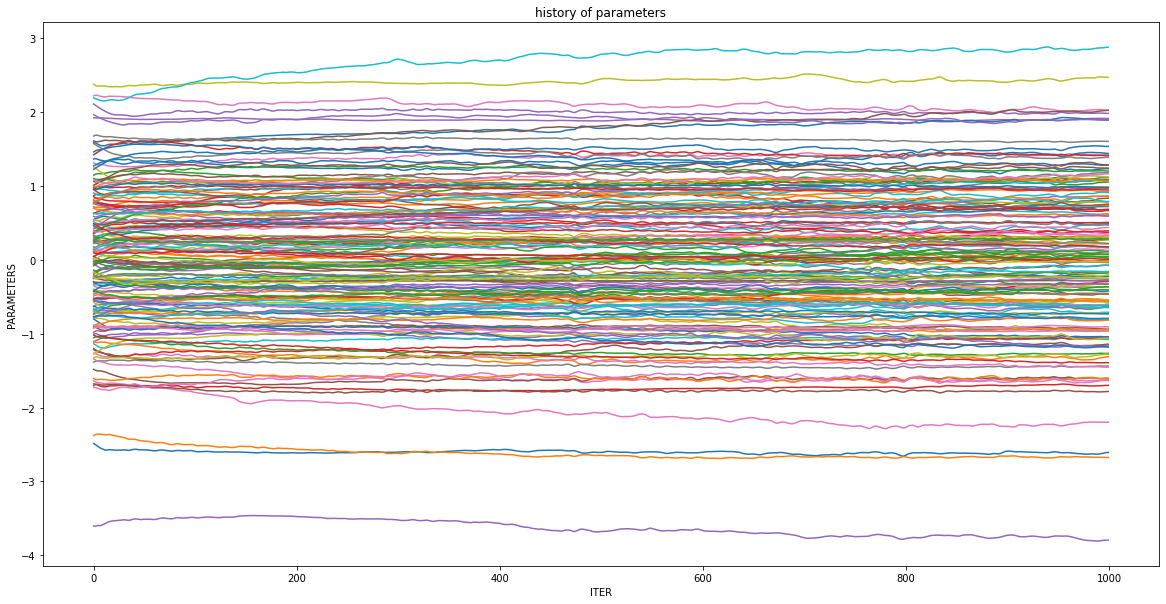

In [ ]:
################## history of parameters ##################
plt.figure(figsize = (20,10))
plt.plot(trainer.history_of_parameters)
plt.title("history of parameters")
plt.xlabel("ITER")
plt.ylabel("PARAMETERS")
plt.show()



In [ ]:
# ###### tensorboard 실행 #######setting.filepath
# !tensorboard --logdir=runs
# from tensorflow import summary
# %load_ext tensorboard
# %tensorboard --logdir logs/tensorboard


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
